In [1]:
import torch
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

print("Howdy")

Howdy


In [2]:
#import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
from diffusers.utils import load_image
#from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

device = "cpu"

# switch to "mps" for apple devices
#pipe = DiffusionPipeline.from_pretrained("lambdalabs/sd-image-variations-diffusers", dtype=torch.bfloat16, device_map="cuda")
#pipe = StableDiffusionImageVariationPipeline.from_pretrained("/home/kojo/Code/sd-image-variations-diffusers/", local_files_only=True)
pipe = StableDiffusionPipeline.from_single_file("/home/kojo/Code/stable-diffusion-v1-5/v1-5-pruned-emaonly.safetensors").to(device)
pipe.feature_extractor = None

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
# Offloading the weights to the CPU and only loading them on the GPU can reduce memory consumption to less than 3GB.
pipe.enable_model_cpu_offload()

# Tighter ordering of memory tensors.
pipe.unet.to(memory_format=torch.channels_last)

# # Decoding large batches of images with limited VRAM or batches with 32 images or more by decoding the batches of latents one image at a time.
# pipe.enable_vae_slicing()

# # Splitting the image into overlapping tiles, decoding the tiles, and then blending the outputs together to compose the final image. 
# pipe.enable_vae_tiling()

pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.36.0",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [6]:
pipe.load_ip_adapter("/home/kojo/Code/IP-Adapter/", subfolder="models", weight_name="ip-adapter-plus_sd15.safetensors", image_encoder_folder="image_encoder", local_files_only=True)

`torch_dtype` is deprecated! Use `dtype` instead!


In [7]:
pipe.image_encoder = pipe.image_encoder.to(device)

In [8]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.36.0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
# from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

# image_encoder = CLIPVisionModelWithProjection.from_pretrained(
#     "/home/kojo/Code/IP-Adapter/", 
#     subfolder="models/image_encoder", 
#     local_files_only=True
# ).to(device)

# feature_extractor = CLIPImageProcessor.from_pretrained(
#     "/home/kojo/Code/IP-Adapter/", 
#     subfolder="models/image_encoder",
#     local_files_only=True
# )

In [ ]:
import numpy as np

def white_bg(image):
    black_mask = np.all(np.array(image) < [10, 10, 10], axis=2)

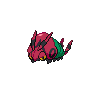

In [47]:
def get_embedding(image):
    image_features = pipe.feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        #image_features = feature_extractor(images=image, return_tensors="pt").pixel_values
        
        #embedding = image_encoder(image_features).image_embeds
        #embedding = pipe.image_encoder(image_features).image_embeds
        outputs = pipe.image_encoder(image_features, output_hidden_states=True)
        embedding = outputs.hidden_states[-2]
        
        #embedding = embedding / embedding.norm(dim=-1, keepdim=True)
    return embedding

starting_image = load_image("./venipede_white.png")
starting_image

In [48]:
starting_embed = get_embedding(starting_image)
starting_embed.shape

torch.Size([1, 257, 1280])

In [49]:
starting_embed

tensor([[[ 0.3886, -0.0533,  0.4229,  ...,  0.3524, -0.0128, -0.6123],
         [-0.4270, -0.1065,  0.1515,  ...,  0.4298, -0.1198, -0.8234],
         [-0.2832, -0.2966,  0.6646,  ...,  0.2380,  0.0295, -0.4331],
         ...,
         [-0.1486,  0.2740, -0.1233,  ...,  0.2429,  0.2548, -0.0689],
         [ 0.6226,  0.3396,  0.0097,  ...,  0.2204,  0.1655,  0.3973],
         [-0.3992, -0.0142,  0.2465,  ...,  0.5125, -0.2133, -0.8771]]],
       device='cuda:0')

In [50]:
#starting_embeds = starting_embed
starting_embeds = torch.unsqueeze(starting_embed, 0)
starting_embeds.shape

torch.Size([1, 1, 257, 1280])

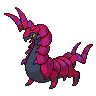

In [29]:
#prompt = "Turn this cat into a dog"
input_image = load_image("./scolipede.png")

input_image

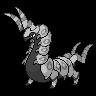

In [35]:
input_image.getchannel(0)

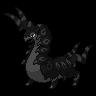

In [36]:
input_image.getchannel(1)

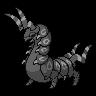

In [37]:
input_image.getchannel(2)

In [ ]:
#input_image.getchannel(3)

ValueError: band index out of range

In [51]:
negative_embed = torch.zeros_like(starting_embeds)
negative_embed.shape

torch.Size([1, 1, 257, 1280])

In [52]:
combined_embeds = torch.cat([negative_embed, starting_embeds], dim=0)
combined_embeds.shape

torch.Size([2, 1, 257, 1280])

  0%|          | 0/30 [00:00<?, ?it/s]

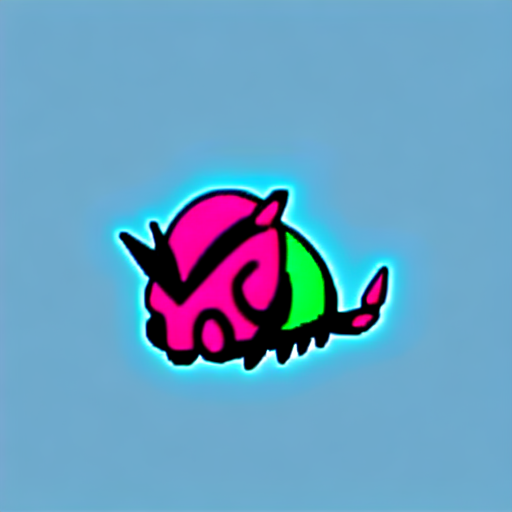

In [53]:
generator = torch.Generator(device=device).manual_seed(42)
image = pipe(prompt="", ip_adapter_image_embeds=[combined_embeds], guidance_scale=7.5, num_inference_steps=30, generator=generator).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

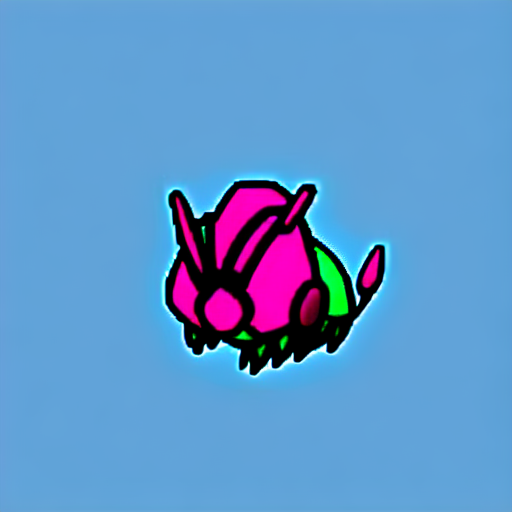

In [54]:
image = pipe(prompt="", ip_adapter_image_embeds=[combined_embeds], guidance_scale=7.5).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

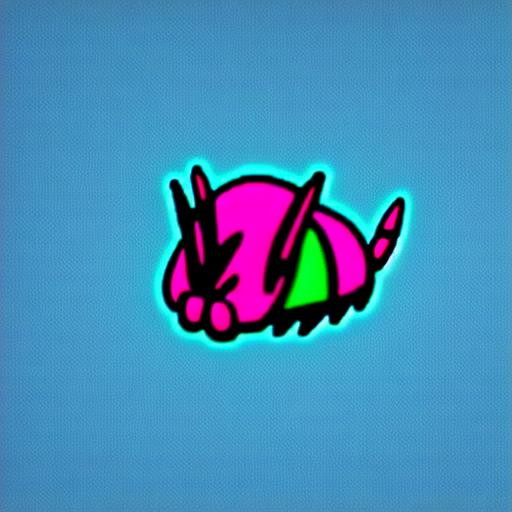

In [55]:
image = pipe(prompt="", ip_adapter_image_embeds=[combined_embeds], guidance_scale=7.5).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

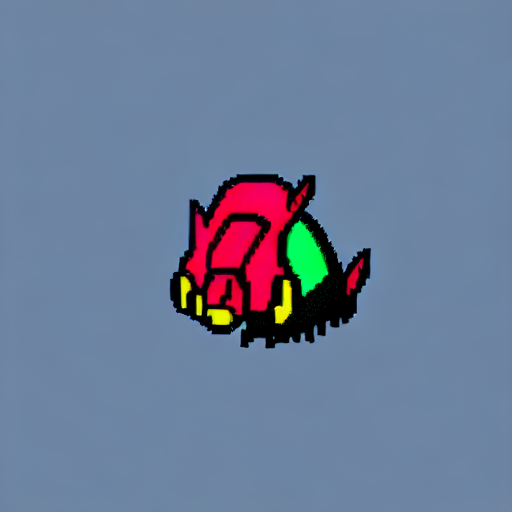

In [56]:
image = pipe(prompt="A pixel art sprite of a pokemon, white background", ip_adapter_image_embeds=[combined_embeds], guidance_scale=3.5).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

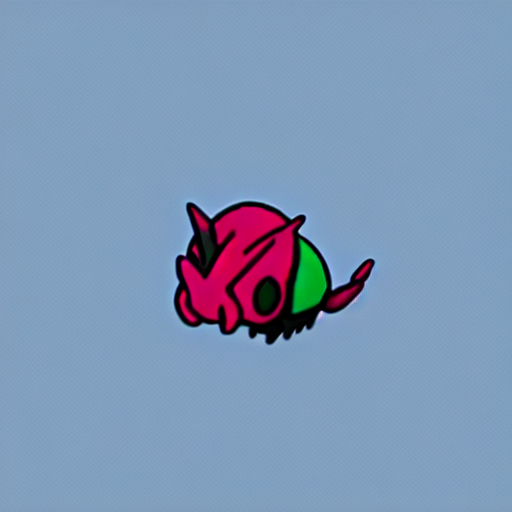

In [57]:
image = pipe(prompt="", ip_adapter_image_embeds=[combined_embeds], guidance_scale=3.5).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

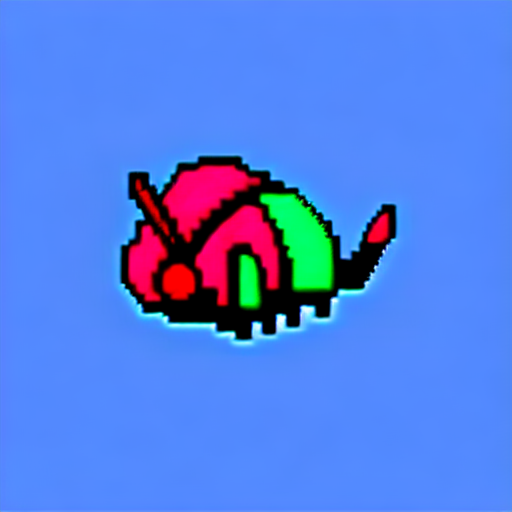

In [58]:
image = pipe(prompt="A pixel art sprite of a pokemon, white background", ip_adapter_image_embeds=[combined_embeds], guidance_scale=7.5).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

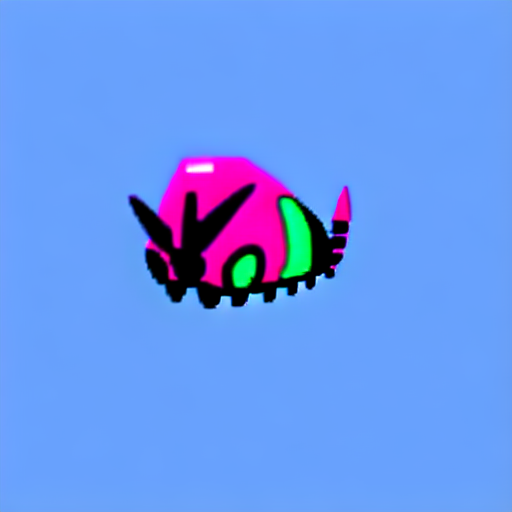

In [30]:
image = pipe(prompt="", image=input_image, ip_adapter_image_embeds=[combined_embeds], strength=0.99, guidance_scale=7.5).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

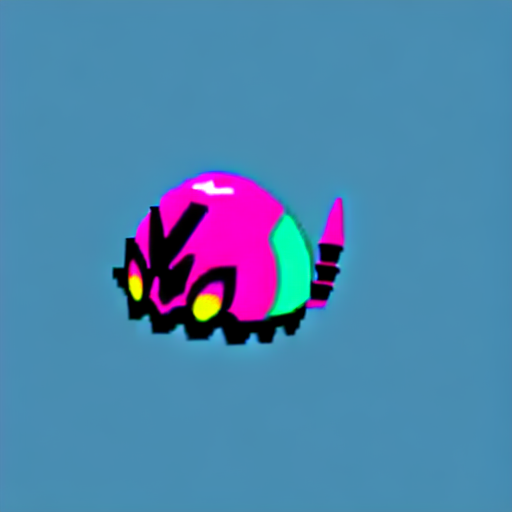

In [31]:
image = pipe(prompt="", image=input_image, ip_adapter_image_embeds=[combined_embeds], strength=0.99, guidance_scale=7.5).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

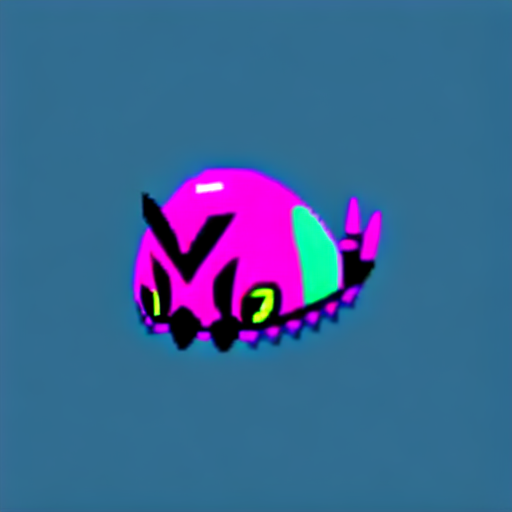

In [32]:
image = pipe(prompt="", image=input_image, ip_adapter_image_embeds=[combined_embeds], strength=0.6, guidance_scale=7.5).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

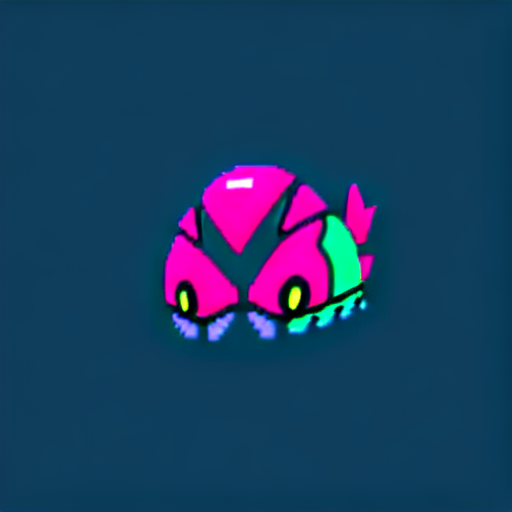

In [33]:
image = pipe(prompt="", image=starting_image, ip_adapter_image_embeds=[combined_embeds], strength=0.99, guidance_scale=7.5).images[0]

image